# Modelagem

In [1]:
import random

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

In [3]:
df = pd.read_csv('waitlist_kidney_brazil_prepared.csv', encoding='iso-8859-1')

In [4]:
df.head()

,date_registered,age_registered,dialysis_session_count,sex,underlying_disease,diabetes,chagas,blood_type,transfusion_count,gestation,prior_transplant,c_pra,hla_a1,hla_a2,hla_b1,hla_b2,hla_dr1,hla_dr2,dr_00,b_00,a_00,anti_hbc,anti_hcv,hbs_ag,event,days_waiting
0,2017-06-29,67,1.0,M,other,True,False,A,0,False,False,0,1,26,44,51,3,7,heterozygous,heterozygous,heterozygous,False,False,False,waiting,392
1,2008-11-03,58,4.0,M,diabetes,False,False,A,0,False,False,0,1,24,18,35,11,0,homozygous,heterozygous,heterozygous,False,False,False,died_waiting,2066
2,2010-07-13,51,2.0,M,hypertension,True,False,O,0,False,False,64,24,25,14,18,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
3,2011-10-03,52,17.0,M,diabetes,False,False,O,0,False,True,2,24,25,14,18,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
4,2006-07-05,67,68.0,M,hypertension,True,False,A,0,False,False,0,24,68,14,27,13,15,heterozygous,heterozygous,heterozygous,False,False,False,died_waiting,194


## Limpeza dos dados

In [5]:
df['date_registered'] = pd.to_datetime(df['date_registered'])

In [6]:
df_clean = df#.drop(columns=['date_registered'])

In [7]:
df_clean['event'].value_counts()

event
removed         14356
transplanted    13732
waiting         10933
died_waiting     9132
Name: count, dtype: int64

Removemos os dados com evento `waiting` ou `removed`, porque representam casos em que um transplante não aconteceu.

In [8]:
df_clean = df_clean[df_clean['event'] == 'transplanted']
df_clean['event'].value_counts()

event
transplanted    13732
Name: count, dtype: int64

Removemos a coluna de evento, que passa a ser redundante.

In [9]:
df_clean = df_clean.drop(columns=['event'])

## Engenharia de Features

In [10]:
df_onehot = pd.get_dummies(df_clean, columns=['sex', 'underlying_disease', 'blood_type', 'dr_00', 'b_00', 'a_00'], drop_first=True)
df_onehot.head()

,date_registered,age_registered,dialysis_session_count,diabetes,chagas,transfusion_count,gestation,prior_transplant,c_pra,hla_a1,hla_a2,hla_b1,hla_b2,hla_dr1,hla_dr2,anti_hbc,anti_hcv,hbs_ag,days_waiting,sex_M,underlying_disease_glomerulonephritis,underlying_disease_hypertension,underlying_disease_other,underlying_disease_pyelonephritis,blood_type_AB,blood_type_B,blood_type_O,dr_00_homozygous,b_00_homozygous,a_00_homozygous
12,2014-08-28,68,14.0,False,False,1,False,False,0,2,3,14,51,1,13,False,False,False,136,True,False,False,False,False,False,True,False,False,False,False
14,2011-07-05,62,12.0,True,False,0,False,False,0,2,68,39,40,4,0,False,False,False,268,True,False,False,True,False,True,False,False,True,False,False
15,2005-06-28,47,1.0,True,False,0,False,False,0,1,2,40,57,4,4,False,False,False,1345,True,False,False,True,False,False,False,True,False,False,False
27,2006-10-03,65,7.0,True,False,0,False,False,0,2,29,44,0,7,11,False,False,False,1283,True,False,False,True,False,False,False,False,False,True,False
28,2012-07-04,33,12.0,True,False,0,False,False,0,2,23,8,44,8,15,False,False,False,464,False,True,False,False,False,False,False,False,False,False,False


In [11]:
df_onehot['idx'] = df_onehot.index

In [12]:
random.seed(1729)


columns = set()
pairs = set()
while len(pairs) < 70_000:
    a = random.randint(1, 13731)
    b = random.randint(0, a-1)
    ra = df_onehot.iloc[a]
    rb = df_onehot.iloc[b]
    for c in df_onehot.columns:
        columns.add(c)
        if ra[c] < rb[c]:
            pairs.add((a,b))
            break
        if rb[c] < ra[c]:
            pairs.add((b,a))
            break


In [13]:
columns

{'age_registered', 'date_registered', 'dialysis_session_count'}

In [14]:
s = []
for _a, _b in pairs:
    a = df_onehot.iloc[_a]
    b = df_onehot.iloc[_b]
    a.index = a.index + '_a'
    b.index = b.index + '_b'
    s.append(pd.concat((a,b)))

In [15]:
df_cross = pd.DataFrame(s)

In [16]:
del s, pairs

In [17]:
df_cross['transplanted_first'] = df_cross['days_waiting_a'] < df_cross['days_waiting_b']

In [18]:
df_cross['transplanted_first'].describe()

count     70000
unique        2
top       False
freq      47807
Name: transplanted_first, dtype: object

In [19]:
df_cross_cln = df_cross.drop(columns=['days_waiting_a', 'days_waiting_b'])

In [20]:
target = 'transplanted_first'
_meta = ['idx_a', 'idx_b', 'date_registered_a', 'date_registered_b']

In [21]:
X, y, meta = df_cross_cln.drop(columns=[target, *_meta]), df_cross_cln[target], df_cross_cln[_meta]

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(X, y, meta, test_size=0.3, random_state=1729)

## Métricas de avaliação

In [23]:
from sklearn.metrics import accuracy_score, roc_auc_score

## Modelos

### Plug-in

Modelo de QDA
Não tem hiperparâmetros, mas é o modelo de separação simples plug-in que a gente conhece ¯\\_(ツ)_/¯


In [24]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [25]:
y_test_qda = qda.predict(X_test)
(roc_auc_score(y_test, y_test_qda), accuracy_score(y_test, y_test_qda))

(0.5040451929821007, 0.5696666666666667)

His ass DID NOT learn shit

In [26]:
y_train_qda = qda.predict(X_train)
(roc_auc_score(y_train, y_train_qda), accuracy_score(y_train, y_train_qda))

(0.5109656052181166, 0.5760612244897959)

0.5231. 0.5236

### Risk-minimization


Modelo de SVC Linear.

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC


In [30]:

linear_svc_params = [
    {
        'linearsvc__penalty': ['l1'],
        'linearsvc__loss': ['squared_hinge'],
        'linearsvc__C': [1,10,100,1000],
    },
    {
        'linearsvc__penalty': ['l2'],
        'linearsvc__loss': ['hinge', 'squared_hinge'],
        'linearsvc__C': [1,10,100,1000],
    },
]

linear_svc_grid = GridSearchCV(
    make_pipeline(StandardScaler(), LinearSVC(dual='auto', random_state=1729, max_iter=10_000)),
    linear_svc_params,
    verbose=4,
    scoring=('roc_auc', 'accuracy'),
    refit='roc_auc')
linear_svc_grid.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l1; accuracy: (test=0.687) roc_auc: (test=0.612) total time=   5.2s
[CV 2/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l1; accuracy: (test=0.690) roc_auc: (test=0.616) total time=   3.5s
[CV 3/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l1; accuracy: (test=0.687) roc_auc: (test=0.619) total time=   4.4s
[CV 4/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l1; accuracy: (test=0.687) roc_auc: (test=0.614) total time=   4.9s
[CV 5/5] END linearsvc__C=1, linearsvc__loss=squared_hinge, linearsvc__penalty=l1; accuracy: (test=0.686) roc_auc: (test=0.619) total time=   4.4s
[CV 1/5] END linearsvc__C=10, linearsvc__loss=squared_hinge, linearsvc__penalty=l1; accuracy: (test=0.687) roc_auc: (test=0.612) total time=   0.4s
[CV 2/5] END linearsvc__C=10, linearsvc__loss=squared_hi

/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END linearsvc__C=100, linearsvc__loss=hinge, linearsvc__penalty=l2; accuracy: (test=0.676) roc_auc: (test=0.490) total time= 4.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END linearsvc__C=100, linearsvc__loss=hinge, linearsvc__penalty=l2; accuracy: (test=0.681) roc_auc: (test=0.495) total time= 4.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END linearsvc__C=100, linearsvc__loss=hinge, linearsvc__penalty=l2; accuracy: (test=0.682) roc_auc: (test=0.514) total time= 4.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END linearsvc__C=100, linearsvc__loss=hinge, linearsvc__penalty=l2; accuracy: (test=0.681) roc_auc: (test=0.500) total time= 4.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END linearsvc__C=100, linearsvc__loss=hinge, linearsvc__penalty=l2; accuracy: (test=0.678) roc_auc: (test=0.513) total time= 4.0min
[CV 1/5] END linearsvc__C=100, linearsvc__loss=squared_hinge, linearsvc__penalty=l2; accuracy: (test=0.687) roc_auc: (test=0.612) total time=   0.7s
[CV 2/5] END linearsvc__C=100, linearsvc__loss=squared_hinge, linearsvc__penalty=l2; accuracy: (test=0.690) roc_auc: (test=0.616) total time=   0.5s
[CV 3/5] END linearsvc__C=100, linearsvc__loss=squared_hinge, linearsvc__penalty=l2; accuracy: (test=0.687) roc_auc: (test=0.619) total time=   0.6s
[CV 4/5] END linearsvc__C=100, linearsvc__loss=squared_hinge, linearsvc__penalty=l2; accuracy: (test=0.687) roc_auc: (test=0.614) total time=   0.6s
[CV 5/5] END linearsvc__C=100, linearsvc__loss=squared_hinge, linearsvc__penalty=l2; accuracy: (test=0.686) roc_auc: (test=0.619) total time=   0.7s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END linearsvc__C=1000, linearsvc__loss=hinge, linearsvc__penalty=l2; accuracy: (test=0.599) roc_auc: (test=0.518) total time= 4.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END linearsvc__C=1000, linearsvc__loss=hinge, linearsvc__penalty=l2; accuracy: (test=0.598) roc_auc: (test=0.529) total time= 4.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END linearsvc__C=1000, linearsvc__loss=hinge, linearsvc__penalty=l2; accuracy: (test=0.557) roc_auc: (test=0.504) total time= 4.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END linearsvc__C=1000, linearsvc__loss=hinge, linearsvc__penalty=l2; accuracy: (test=0.568) roc_auc: (test=0.530) total time= 4.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END linearsvc__C=1000, linearsvc__loss=hinge, linearsvc__penalty=l2; accuracy: (test=0.577) roc_auc: (test=0.497) total time= 4.2min
[CV 1/5] END linearsvc__C=1000, linearsvc__loss=squared_hinge, linearsvc__penalty=l2; accuracy: (test=0.687) roc_auc: (test=0.612) total time=   0.8s
[CV 2/5] END linearsvc__C=1000, linearsvc__loss=squared_hinge, linearsvc__penalty=l2; accuracy: (test=0.690) roc_auc: (test=0.616) total time=   0.6s
[CV 3/5] END linearsvc__C=1000, linearsvc__loss=squared_hinge, linearsvc__penalty=l2; accuracy: (test=0.687) roc_auc: (test=0.619) total time=   0.7s
[CV 4/5] END linearsvc__C=1000, linearsvc__loss=squared_hinge, linearsvc__penalty=l2; accuracy: (test=0.687) roc_auc: (test=0.614) total time=   0.7s
[CV 5/5] END linearsvc__C=1000, linearsvc__loss=squared_hinge, linearsvc__penalty=l2; accuracy: (test=0.686) roc_auc: (test=0.619) total time=   0.7s


GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearsvc',
                                        LinearSVC(dual='auto', max_iter=10000,
                                                  random_state=1729))]),
             param_grid=[{'linearsvc__C': [1, 10, 100, 1000],
                          'linearsvc__loss': ['squared_hinge'],
                          'linearsvc__penalty': ['l1']},
                         {'linearsvc__C': [1, 10, 100, 1000],
                          'linearsvc__loss': ['hinge', 'squared_hinge'],
                          'linearsvc__penalty': ['l2']}],
             refit='roc_auc', scoring=('roc_auc', 'accuracy'), verbose=4)

In [33]:
linear_grid_df = pd.DataFrame(linear_svc_grid.cv_results_)
linear_grid_df.sort_values(['mean_test_roc_auc', 'mean_test_accuracy'], ascending=False)[['mean_fit_time', 'mean_score_time', 'param_linearsvc__C', 'param_linearsvc__loss', 'param_linearsvc__penalty', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_accuracy', 'std_test_accuracy']]

,mean_fit_time,mean_score_time,param_linearsvc__C,param_linearsvc__loss,param_linearsvc__penalty,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,std_test_accuracy
1,0.391979,0.053084,10,squared_hinge,l1,0.616125,0.002946,0.687286,0.001403
0,4.452175,0.048485,1,squared_hinge,l1,0.616125,0.002946,0.687306,0.001394
7,0.585656,0.051091,10,squared_hinge,l2,0.616125,0.002946,0.687286,0.001403
9,0.568206,0.051610,100,squared_hinge,l2,0.616125,0.002946,0.687286,0.001403
2,0.406018,0.055453,100,squared_hinge,l1,0.616125,0.002946,0.687286,0.001403
11,0.635951,0.055734,1000,squared_hinge,l2,0.616125,0.002946,0.687286,0.001403
3,0.362258,0.051799,1000,squared_hinge,l1,0.616125,0.002945,0.687286,0.001403
5,0.545069,0.043976,1,squared_hinge,l2,0.616125,0.002946,0.687286,0.001403
6,90.427121,0.055256,10,hinge,l2,0.515535,0.013400,0.683143,0.000041
10,250.474945,0.047431,1000,hinge,l2,0.515467,0.013062,0.579980,0.016439


In [32]:
y_test_linear_svc = linear_svc_grid.predict(X_test)
(roc_auc_score(y_test, y_test_linear_svc), accuracy_score(y_test, y_test_linear_svc))

(0.5115836477763777, 0.6833333333333333)

## Modelos - separação complexa

### Plug-in

K-Nearest Neighbours

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = [
    {
        'knn__n_neighbors': [3,5,11,25],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan', 'hamming'],
    },
]

knn_grid = GridSearchCV(
    Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
    knn_params,
    verbose=4,
    scoring=('roc_auc', 'accuracy'),
    refit='roc_auc')
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; accuracy: (test=0.648) roc_auc: (test=0.595) total time=   4.9s
[CV 2/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; accuracy: (test=0.649) roc_auc: (test=0.590) total time=   3.8s
[CV 3/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; accuracy: (test=0.654) roc_auc: (test=0.606) total time=   4.6s
[CV 4/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; accuracy: (test=0.653) roc_auc: (test=0.600) total time=   4.2s
[CV 5/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; accuracy: (test=0.654) roc_auc: (test=0.598) total time=   4.5s
[CV 1/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance; accuracy: (test=0.648) roc_auc: (test=0.602) total time=   3.2s
[CV 2/5] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance; accura

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=[{'knn__metric': ['euclidean', 'manhattan', 'hamming'],
                          'knn__n_neighbors': [3, 5, 11, 25],
                          'knn__weights': ['uniform', 'distance']}],
             refit='roc_auc', scoring=('roc_auc', 'accuracy'), verbose=4)

In [35]:
knn_grid_df = pd.DataFrame(knn_grid.cv_results_)
knn_grid_df.sort_values(['mean_test_roc_auc', 'mean_test_accuracy'], ascending=False)[['mean_fit_time', 'mean_score_time', 'param_knn__n_neighbors', 'param_knn__weights', 'param_knn__metric', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_accuracy', 'std_test_accuracy']]

,mean_fit_time,mean_score_time,param_knn__n_neighbors,param_knn__weights,param_knn__metric,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,std_test_accuracy
21,0.103019,76.943582,11,distance,hamming,0.793647,0.005053,0.753694,0.003910
20,0.108160,77.157954,11,uniform,hamming,0.781126,0.004733,0.751041,0.003580
19,0.101309,76.990658,5,distance,hamming,0.778447,0.006377,0.756061,0.004758
18,0.104735,77.333661,5,uniform,hamming,0.772393,0.005764,0.756122,0.004708
23,0.096884,74.740890,25,distance,hamming,0.770443,0.005770,0.726837,0.001315
22,0.104579,76.562864,25,uniform,hamming,0.750262,0.005800,0.720224,0.001733
17,0.099026,74.847856,3,distance,hamming,0.742002,0.006420,0.741265,0.003473
16,0.109604,75.828040,3,uniform,hamming,0.738610,0.005640,0.741367,0.003509
15,0.108639,20.149382,25,distance,manhattan,0.670729,0.005715,0.697633,0.001934
13,0.110010,19.914597,11,distance,manhattan,0.668888,0.007113,0.697653,0.003481


In [36]:
y_test_knn = knn_grid.predict(X_test)
(roc_auc_score(y_test, y_test_knn), accuracy_score(y_test, y_test_knn))

(0.6606290961528111, 0.7605238095238095)

### Risk minimization

Modelo de SVC com Kernel não linear

In [27]:
svc_params = [
    {
        'svc__C': [1, 10],
        'svc__kernel': ['poly'],
        'svc__degree': [3, 5],
        'svc__gamma': ['scale', 0.1, 1, 2],
        'svc__coef0': [0, -1, 1],
    },
    {
        'svc__C': [1, 10],
        'svc__kernel': ['rbf', 'sigmoid'],
        'svc__gamma': ['scale', 0.1, 1, 2],
    },
]

svc_grid = GridSearchCV(
    Pipeline(steps=[('scaler',StandardScaler()), ('svc', SVC(random_state=1729, max_iter=10_000, cache_size=2000))]),
    svc_params,
    verbose=4,
    scoring=('roc_auc', 'accuracy'),
    refit='roc_auc')
svc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.453) roc_auc: (test=0.605) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.410) roc_auc: (test=0.590) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.432) roc_auc: (test=0.592) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.399) roc_auc: (test=0.593) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.436) roc_auc: (test=0.602) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.548) roc_auc: (test=0.535) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.541) roc_auc: (test=0.534) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.548) roc_auc: (test=0.534) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.542) roc_auc: (test=0.525) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.554) roc_auc: (test=0.533) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.552) roc_auc: (test=0.536) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.541) roc_auc: (test=0.530) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.551) roc_auc: (test=0.535) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.542) roc_auc: (test=0.526) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.548) roc_auc: (test=0.531) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.552) roc_auc: (test=0.536) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.541) roc_auc: (test=0.530) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.551) roc_auc: (test=0.535) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.542) roc_auc: (test=0.526) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.548) roc_auc: (test=0.531) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.439) roc_auc: (test=0.599) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.424) roc_auc: (test=0.584) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.425) roc_auc: (test=0.591) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.420) roc_auc: (test=0.595) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.421) roc_auc: (test=0.593) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.611) roc_auc: (test=0.567) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.607) roc_auc: (test=0.558) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.614) roc_auc: (test=0.567) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.609) roc_auc: (test=0.554) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.611) roc_auc: (test=0.561) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.611) roc_auc: (test=0.567) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.605) roc_auc: (test=0.559) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.612) roc_auc: (test=0.567) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.610) roc_auc: (test=0.554) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.611) roc_auc: (test=0.563) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.611) roc_auc: (test=0.567) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.605) roc_auc: (test=0.559) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.612) roc_auc: (test=0.567) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.610) roc_auc: (test=0.554) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.611) roc_auc: (test=0.563) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.515) roc_auc: (test=0.510) total time= 2.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.576) roc_auc: (test=0.500) total time= 2.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.569) roc_auc: (test=0.498) total time= 2.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.541) roc_auc: (test=0.518) total time= 2.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.426) roc_auc: (test=0.515) total time= 2.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.570) roc_auc: (test=0.512) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.566) roc_auc: (test=0.505) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.562) roc_auc: (test=0.497) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.584) roc_auc: (test=0.505) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.581) roc_auc: (test=0.524) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.491) roc_auc: (test=0.524) total time=  32.9s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.491) roc_auc: (test=0.526) total time=  36.0s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.485) roc_auc: (test=0.511) total time=  32.5s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.492) roc_auc: (test=0.519) total time=  36.3s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.483) roc_auc: (test=0.515) total time=  35.1s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.496) roc_auc: (test=0.541) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.501) roc_auc: (test=0.543) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.508) roc_auc: (test=0.535) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.501) roc_auc: (test=0.539) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.502) roc_auc: (test=0.538) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.567) roc_auc: (test=0.510) total time= 2.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.573) roc_auc: (test=0.491) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.565) roc_auc: (test=0.495) total time= 2.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.582) roc_auc: (test=0.517) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.582) roc_auc: (test=0.517) total time= 2.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.487) roc_auc: (test=0.502) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.539) roc_auc: (test=0.515) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.544) roc_auc: (test=0.527) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.558) roc_auc: (test=0.526) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.535) roc_auc: (test=0.512) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.589) roc_auc: (test=0.560) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.579) roc_auc: (test=0.554) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.592) roc_auc: (test=0.561) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.579) roc_auc: (test=0.548) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.587) roc_auc: (test=0.554) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.610) roc_auc: (test=0.569) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.599) roc_auc: (test=0.555) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.602) roc_auc: (test=0.567) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.595) roc_auc: (test=0.549) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.600) roc_auc: (test=0.556) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.574) roc_auc: (test=0.535) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.581) roc_auc: (test=0.532) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.563) roc_auc: (test=0.537) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.576) roc_auc: (test=0.544) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.566) roc_auc: (test=0.542) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.573) roc_auc: (test=0.536) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.562) roc_auc: (test=0.523) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.574) roc_auc: (test=0.528) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.570) roc_auc: (test=0.532) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.590) roc_auc: (test=0.539) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.571) roc_auc: (test=0.546) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.561) roc_auc: (test=0.535) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.571) roc_auc: (test=0.542) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.558) roc_auc: (test=0.523) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.570) roc_auc: (test=0.531) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.558) roc_auc: (test=0.536) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.544) roc_auc: (test=0.524) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.565) roc_auc: (test=0.537) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.550) roc_auc: (test=0.525) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.560) roc_auc: (test=0.531) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.614) roc_auc: (test=0.552) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.602) roc_auc: (test=0.537) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.614) roc_auc: (test=0.553) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.601) roc_auc: (test=0.535) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.609) roc_auc: (test=0.554) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.624) roc_auc: (test=0.576) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.609) roc_auc: (test=0.558) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.628) roc_auc: (test=0.568) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.625) roc_auc: (test=0.564) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.616) roc_auc: (test=0.568) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.623) roc_auc: (test=0.572) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.614) roc_auc: (test=0.561) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.626) roc_auc: (test=0.573) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.620) roc_auc: (test=0.564) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.613) roc_auc: (test=0.564) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.617) roc_auc: (test=0.572) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.612) roc_auc: (test=0.560) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.622) roc_auc: (test=0.573) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.618) roc_auc: (test=0.559) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.605) roc_auc: (test=0.558) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.546) roc_auc: (test=0.563) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.539) roc_auc: (test=0.554) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.539) roc_auc: (test=0.558) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.541) roc_auc: (test=0.560) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.533) roc_auc: (test=0.554) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.542) roc_auc: (test=0.531) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.541) roc_auc: (test=0.530) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.551) roc_auc: (test=0.535) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.551) roc_auc: (test=0.535) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.548) roc_auc: (test=0.531) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.552) roc_auc: (test=0.536) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.541) roc_auc: (test=0.530) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.551) roc_auc: (test=0.535) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.542) roc_auc: (test=0.526) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.548) roc_auc: (test=0.531) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.552) roc_auc: (test=0.536) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.541) roc_auc: (test=0.530) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.551) roc_auc: (test=0.535) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.542) roc_auc: (test=0.526) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.548) roc_auc: (test=0.531) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.608) roc_auc: (test=0.593) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.607) roc_auc: (test=0.585) total time= 1.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.613) roc_auc: (test=0.592) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.609) roc_auc: (test=0.588) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.608) roc_auc: (test=0.590) total time= 1.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.611) roc_auc: (test=0.567) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.607) roc_auc: (test=0.558) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.614) roc_auc: (test=0.567) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.609) roc_auc: (test=0.554) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.611) roc_auc: (test=0.561) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.611) roc_auc: (test=0.567) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.605) roc_auc: (test=0.559) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.612) roc_auc: (test=0.567) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.610) roc_auc: (test=0.554) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.611) roc_auc: (test=0.563) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.611) roc_auc: (test=0.567) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.605) roc_auc: (test=0.559) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.612) roc_auc: (test=0.567) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.610) roc_auc: (test=0.554) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=0, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.611) roc_auc: (test=0.563) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.583) roc_auc: (test=0.509) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.503) roc_auc: (test=0.506) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.570) roc_auc: (test=0.497) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.513) roc_auc: (test=0.508) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.597) roc_auc: (test=0.521) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.571) roc_auc: (test=0.512) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.560) roc_auc: (test=0.513) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.565) roc_auc: (test=0.498) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.583) roc_auc: (test=0.505) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.566) roc_auc: (test=0.515) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.491) roc_auc: (test=0.524) total time=  28.0s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.491) roc_auc: (test=0.526) total time=  30.6s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.482) roc_auc: (test=0.507) total time=  27.1s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.491) roc_auc: (test=0.521) total time=  30.4s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.488) roc_auc: (test=0.518) total time=  30.2s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.496) roc_auc: (test=0.541) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.501) roc_auc: (test=0.543) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.508) roc_auc: (test=0.535) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.501) roc_auc: (test=0.539) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.502) roc_auc: (test=0.538) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.576) roc_auc: (test=0.509) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.572) roc_auc: (test=0.505) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.562) roc_auc: (test=0.494) total time= 2.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.582) roc_auc: (test=0.517) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.579) roc_auc: (test=0.513) total time= 1.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.553) roc_auc: (test=0.527) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.503) roc_auc: (test=0.510) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.541) roc_auc: (test=0.526) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.551) roc_auc: (test=0.527) total time= 1.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.540) roc_auc: (test=0.513) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.589) roc_auc: (test=0.560) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.579) roc_auc: (test=0.554) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.592) roc_auc: (test=0.561) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.579) roc_auc: (test=0.548) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.587) roc_auc: (test=0.554) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.610) roc_auc: (test=0.569) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.599) roc_auc: (test=0.555) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.602) roc_auc: (test=0.567) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.595) roc_auc: (test=0.549) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=-1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.600) roc_auc: (test=0.556) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.573) roc_auc: (test=0.530) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.573) roc_auc: (test=0.526) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.563) roc_auc: (test=0.516) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.568) roc_auc: (test=0.515) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.552) roc_auc: (test=0.513) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.585) roc_auc: (test=0.544) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.567) roc_auc: (test=0.528) total time=  59.3s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.574) roc_auc: (test=0.531) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.559) roc_auc: (test=0.523) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.568) roc_auc: (test=0.523) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.571) roc_auc: (test=0.546) total time=  58.8s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.561) roc_auc: (test=0.535) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.571) roc_auc: (test=0.542) total time=  59.3s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.558) roc_auc: (test=0.523) total time=  59.4s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.570) roc_auc: (test=0.531) total time=  58.6s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.558) roc_auc: (test=0.536) total time=  58.9s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.544) roc_auc: (test=0.524) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.565) roc_auc: (test=0.537) total time=  58.7s


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.550) roc_auc: (test=0.525) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=3, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.560) roc_auc: (test=0.531) total time= 1.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.596) roc_auc: (test=0.541) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.593) roc_auc: (test=0.538) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.602) roc_auc: (test=0.549) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.588) roc_auc: (test=0.524) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=scale, svc__kernel=poly; accuracy: (test=0.601) roc_auc: (test=0.542) total time= 1.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.624) roc_auc: (test=0.576) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.609) roc_auc: (test=0.558) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.628) roc_auc: (test=0.568) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.625) roc_auc: (test=0.564) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=0.1, svc__kernel=poly; accuracy: (test=0.616) roc_auc: (test=0.568) total time= 1.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.623) roc_auc: (test=0.572) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.614) roc_auc: (test=0.561) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.626) roc_auc: (test=0.573) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.620) roc_auc: (test=0.564) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=1, svc__kernel=poly; accuracy: (test=0.613) roc_auc: (test=0.564) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.617) roc_auc: (test=0.572) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.612) roc_auc: (test=0.560) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.622) roc_auc: (test=0.573) total time= 1.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.618) roc_auc: (test=0.559) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__coef0=1, svc__degree=5, svc__gamma=2, svc__kernel=poly; accuracy: (test=0.605) roc_auc: (test=0.558) total time= 1.4min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.673) roc_auc: (test=0.608) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.671) roc_auc: (test=0.612) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.676) roc_auc: (test=0.611) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.674) roc_auc: (test=0.619) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.670) roc_auc: (test=0.614) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.570) roc_auc: (test=0.496) total time= 2.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.563) roc_auc: (test=0.495) total time= 2.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.559) roc_auc: (test=0.506) total time= 2.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.566) roc_auc: (test=0.496) total time= 2.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.566) roc_auc: (test=0.500) total time= 2.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.654) roc_auc: (test=0.600) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.656) roc_auc: (test=0.600) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.656) roc_auc: (test=0.612) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.651) roc_auc: (test=0.616) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.643) roc_auc: (test=0.603) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.597) roc_auc: (test=0.504) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.587) roc_auc: (test=0.495) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.588) roc_auc: (test=0.497) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.585) roc_auc: (test=0.506) total time= 2.9min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.596) roc_auc: (test=0.489) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.362) roc_auc: (test=0.544) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.362) roc_auc: (test=0.555) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.363) roc_auc: (test=0.550) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.395) roc_auc: (test=0.557) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.362) roc_auc: (test=0.547) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.572) roc_auc: (test=0.503) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.556) roc_auc: (test=0.502) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.573) roc_auc: (test=0.509) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.568) roc_auc: (test=0.517) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.569) roc_auc: (test=0.511) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.568) roc_auc: (test=0.548) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.571) roc_auc: (test=0.553) total time= 2.3min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.566) roc_auc: (test=0.558) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.569) roc_auc: (test=0.558) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.641) roc_auc: (test=0.549) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=1, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.575) roc_auc: (test=0.504) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=1, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.574) roc_auc: (test=0.515) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=1, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.583) roc_auc: (test=0.515) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=1, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.580) roc_auc: (test=0.517) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=1, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.573) roc_auc: (test=0.507) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.629) roc_auc: (test=0.553) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.622) roc_auc: (test=0.558) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.637) roc_auc: (test=0.560) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.650) roc_auc: (test=0.581) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=scale, svc__kernel=rbf; accuracy: (test=0.636) roc_auc: (test=0.560) total time= 1.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.570) roc_auc: (test=0.497) total time= 2.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.574) roc_auc: (test=0.489) total time= 2.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.580) roc_auc: (test=0.503) total time= 2.5min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.580) roc_auc: (test=0.502) total time= 2.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=scale, svc__kernel=sigmoid; accuracy: (test=0.580) roc_auc: (test=0.496) total time= 2.6min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.579) roc_auc: (test=0.599) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.579) roc_auc: (test=0.592) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.585) roc_auc: (test=0.607) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.590) roc_auc: (test=0.613) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=0.1, svc__kernel=rbf; accuracy: (test=0.587) roc_auc: (test=0.608) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.592) roc_auc: (test=0.496) total time= 2.8min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.584) roc_auc: (test=0.490) total time= 2.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.583) roc_auc: (test=0.500) total time= 2.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.588) roc_auc: (test=0.495) total time= 2.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=0.1, svc__kernel=sigmoid; accuracy: (test=0.593) roc_auc: (test=0.496) total time= 2.7min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.672) roc_auc: (test=0.543) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.672) roc_auc: (test=0.555) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.356) roc_auc: (test=0.550) total time= 2.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.671) roc_auc: (test=0.557) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=1, svc__kernel=rbf; accuracy: (test=0.674) roc_auc: (test=0.546) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.574) roc_auc: (test=0.503) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.553) roc_auc: (test=0.502) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.572) roc_auc: (test=0.509) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.572) roc_auc: (test=0.516) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=1, svc__kernel=sigmoid; accuracy: (test=0.570) roc_auc: (test=0.510) total time= 3.1min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.324) roc_auc: (test=0.542) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.323) roc_auc: (test=0.547) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.324) roc_auc: (test=0.554) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.326) roc_auc: (test=0.554) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=2, svc__kernel=rbf; accuracy: (test=0.322) roc_auc: (test=0.545) total time= 2.2min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END svc__C=10, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.574) roc_auc: (test=0.504) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END svc__C=10, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.573) roc_auc: (test=0.514) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END svc__C=10, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.573) roc_auc: (test=0.519) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END svc__C=10, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.579) roc_auc: (test=0.517) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END svc__C=10, svc__gamma=2, svc__kernel=sigmoid; accuracy: (test=0.573) roc_auc: (test=0.498) total time= 3.0min


/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc',
                                        SVC(cache_size=2000, max_iter=10000,
                                            random_state=1729))]),
             param_grid=[{'svc__C': [1, 10], 'svc__coef0': [0, -1, 1],
                          'svc__degree': [3, 5],
                          'svc__gamma': ['scale', 0.1, 1, 2],
                          'svc__kernel': ['poly']},
                         {'svc__C': [1, 10], 'svc__gamma': ['scale', 0.1, 1, 2],
                          'svc__kernel': ['rbf', 'sigmoid']}],
             refit='roc_auc', scoring=('roc_auc', 'accuracy'), verbose=4)

In [30]:
svc_grid_df = pd.DataFrame(svc_grid.cv_results_)
svc_grid_df.sort_values(['mean_test_roc_auc', 'mean_test_accuracy'], ascending=False)[['mean_fit_time', 'mean_score_time', 'param_svc__C', 'param_svc__kernel', 'param_svc__degree', 'param_svc__gamma', 'param_svc__coef0', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_accuracy', 'std_test_accuracy']]

,mean_fit_time,mean_score_time,param_svc__C,param_svc__kernel,param_svc__degree,param_svc__gamma,param_svc__coef0,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,std_test_accuracy
48,93.283118,40.347944,1,rbf,NaN,scale,NaN,0.612778,0.003899,0.672776,0.001933
50,93.698278,40.379417,1,rbf,NaN,0.1,NaN,0.606076,0.006482,0.651857,0.004827
58,89.320445,38.644683,10,rbf,NaN,0.1,NaN,0.603819,0.007159,0.584082,0.004283
0,104.762116,25.558821,1,poly,3,scale,0,0.596647,0.006104,0.426082,0.019184
4,104.416923,25.649395,1,poly,5,scale,0,0.592280,0.004786,0.425776,0.007149
28,83.830924,21.480408,10,poly,5,scale,0,0.589620,0.002821,0.609122,0.002033
21,68.771694,18.635784,1,poly,5,0.1,1,0.566696,0.005958,0.620469,0.006851
45,57.035934,15.835712,10,poly,5,0.1,1,0.566696,0.005958,0.620469,0.006851
22,75.689303,20.272690,1,poly,5,1,1,0.566663,0.004850,0.619204,0.004896
46,62.707410,17.270974,10,poly,5,1,1,0.566663,0.004850,0.619204,0.004896


In [31]:
y_test_svc = svc_grid.predict(X_test)
(roc_auc_score(y_test, y_test_svc), accuracy_score(y_test, y_test_svc))

(0.5751220479860679, 0.6281428571428571)

## Risco bayesiano

In [29]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

forest_params = [
    {
        'pca': ['passthrough'],
        'forest__n_estimators': [500, 1000, 1500],
        'forest__min_samples_split': [2, 10],
        'forest__max_features': ['sqrt', 'log2'],
    },
    {
        'pca': [PCA(random_state=1729)],
        'pca__n_components': [10, 30],
        'forest__n_estimators': [1000,1500],
        'forest__min_samples_split': [2, 10],
        'forest__max_features': ['sqrt', 'log2'],
    },
]


forest_grid = GridSearchCV(
    Pipeline(steps=[('pca', PCA(random_state=1729)), ('forest', RandomForestClassifier(random_state=1729, n_jobs=3))]),
    forest_params,
    verbose=4,
    scoring=('roc_auc', 'accuracy'),
    refit='roc_auc')
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=500, pca=passthrough; accuracy: (test=0.712) roc_auc: (test=0.734) total time=  20.5s
[CV 2/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=500, pca=passthrough; accuracy: (test=0.712) roc_auc: (test=0.725) total time=  20.2s
[CV 3/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=500, pca=passthrough; accuracy: (test=0.719) roc_auc: (test=0.739) total time=  20.5s
[CV 4/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=500, pca=passthrough; accuracy: (test=0.718) roc_auc: (test=0.744) total time=  20.0s
[CV 5/5] END forest__max_features=sqrt, forest__min_samples_split=2, forest__n_estimators=500, pca=passthrough; accuracy: (test=0.722) roc_auc: (test=0.743) total time=  20.6s
[CV 1/5] END forest__max_features=sqrt, forest__min_sample

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA(random_state=1729)),
                                       ('forest',
                                        RandomForestClassifier(n_jobs=3,
                                                               random_state=1729))]),
             param_grid=[{'forest__max_features': ['sqrt', 'log2'],
                          'forest__min_samples_split': [2, 10],
                          'forest__n_estimators': [500, 1000, 1500],
                          'pca': ['passthrough']},
                         {'forest__max_features': ['sqrt', 'log2'],
                          'forest__min_samples_split': [2, 10],
                          'forest__n_estimators': [1000, 1500],
                          'pca': [PCA(random_state=1729)],
                          'pca__n_components': [10, 30]}],
             refit='roc_auc', scoring=('roc_auc', 'accuracy'), verbose=4)

In [30]:
forest_grid_df = pd.DataFrame(forest_grid.cv_results_)
forest_grid_df.sort_values(['mean_test_roc_auc', 'mean_test_accuracy'], ascending=False)[['mean_fit_time', 'mean_score_time', 'param_pca__n_components', 'param_forest__n_estimators', 'param_forest__min_samples_split', 'param_forest__max_features', 'mean_test_roc_auc', 'std_test_roc_auc', 'mean_test_accuracy', 'std_test_accuracy']]

,mean_fit_time,mean_score_time,param_pca__n_components,param_forest__n_estimators,param_forest__min_samples_split,param_forest__max_features,mean_test_roc_auc,std_test_roc_auc,mean_test_accuracy,std_test_accuracy
8,49.175018,4.178482,NaN,1500,2,log2,0.742667,0.007158,0.715000,0.002547
7,32.058409,2.972271,NaN,1000,2,log2,0.741988,0.007380,0.715367,0.002702
2,56.819780,4.167170,NaN,1500,2,sqrt,0.740035,0.006851,0.716714,0.003459
6,15.787638,1.505216,NaN,500,2,log2,0.739354,0.007405,0.715163,0.003816
1,37.932542,2.850290,NaN,1000,2,sqrt,0.739039,0.006713,0.717000,0.003326
0,18.896604,1.458573,NaN,500,2,sqrt,0.736948,0.006827,0.716633,0.003683
11,40.374079,3.609113,NaN,1500,10,log2,0.731664,0.006440,0.711286,0.002564
10,25.323229,2.175305,NaN,1000,10,log2,0.731165,0.006351,0.711531,0.002229
5,51.825002,3.438959,NaN,1500,10,sqrt,0.730338,0.006957,0.713163,0.003557
4,35.041371,2.363324,NaN,1000,10,sqrt,0.729598,0.006950,0.713367,0.002737


In [31]:
y_test_forest = forest_grid.predict_proba(X_test)[:,1]
y_test_forest_05 = y_test_forest > 0.5
(roc_auc_score(y_test, y_test_forest_05), accuracy_score(y_test, y_test_forest_05))

(0.5740550846594279, 0.7186190476190476)

#### Risco bayesiano

Cálculo da razão de verossimilhança. Aqui fazemos a mesma assumpção do notebook que $\mathcal{L}(x|Y=y) = \hat p (y|x)$

In [72]:
L_y_test_forest = y_test_forest / (1 - y_test_forest)
L_y_test_forest_1 = (L_y_test_forest > 1)

In [73]:
(roc_auc_score(y_test, L_y_test_forest_1), accuracy_score(y_test, L_y_test_forest_1))

(0.6766058411123146, 0.6766190476190476)

Disitribuição das classes no dado original:

In [81]:
y_test.mean()

0.49742857142857144

Risco padrão: $\eta = 1$

No nosso caso, o problema é inerentemente simétrico. Como existem poucos pacientes transplantados no mesmo dia, podemos desconsiderá-los. Então, dados dois pacientes quaisquer $p$ e $q$, existe uma ordem absoluta entre $p$ e $q$ e a chance de aleatoriamente escolher $(p, q)$ é a mesma de escolher $(q, p)$. Logo, o problema é balanceado.

Também podemos observar que um falso positivo para $(p, q)$ é equivalente a um falso negativo para $(q, p)$. Logo, os custos para falsos negativos e positivos devem serem os mesmos e, portanto, o limite bayesiano é igual ao risco padrão.

In [74]:
(L_y_test_forest > 1).mean()

0.49652380952380953

Abaixo, tentamos encontrar o limite que aproxima a distribuição de classes entre o dado original e o dado previsto

In [80]:
(L_y_test_forest > 0.999).mean()

0.4989523809523809

In [82]:
(L_y_test_forest > 0.9999).mean()

0.4989523809523809

Como não existe alteração entre limite 0.999 e 0.9999 e com limite 1 obtemos uma distribuição menor que no dado original e limite 0.999 obtemos uma distribuição maior, estas são as melhores aproximações possíveis para a distibuição original.

### Calibração

In [22]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=200, max_features='log2')
forest.fit(X_train, y_train)
y_test_forest_2 = forest.predict_proba(X_test)[:,1]

In [23]:
import matplotlib.pyplot as plt

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(y_test_forest_2.reshape(-1,1), y_test)

LogisticRegression()

Brier score original 0.2161959833333333
Brier score pós-calibração 0.21043668129783596


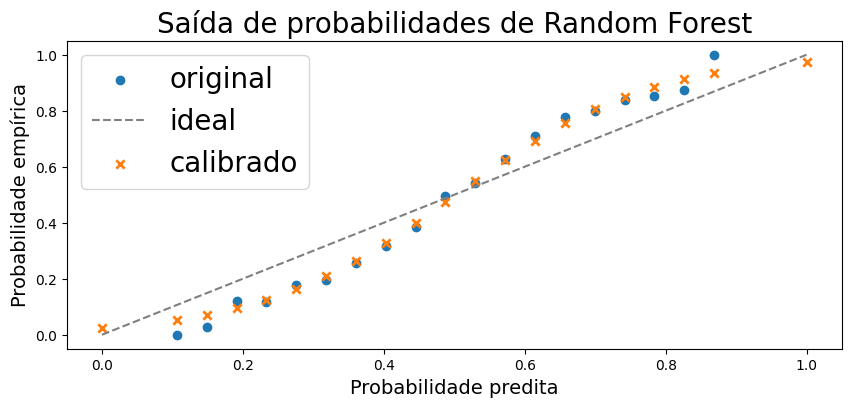

In [25]:
from sklearn.metrics import brier_score_loss
pred_probs_space = np.linspace(y_test_forest_2.min(), y_test_forest_2.max(), 20)

empirical_probs = []
pred_probs_midpoints = []

for i in range(len(pred_probs_space)-1):
    empirical_probs.append(np.mean(y_test[(y_test_forest_2 > pred_probs_space[i]) & (y_test_forest_2 < pred_probs_space[i+1])]))
    pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)


calibrated_probs = lr.predict_proba(np.array([0.0]+pred_probs_midpoints+[1.0]).reshape(-1,1))[:,1]
print('Brier score original', brier_score_loss(y_test, y_test_forest_2.reshape(-1,1)))
print('Brier score pós-calibração', brier_score_loss(y_test, lr.predict_proba(y_test_forest_2.reshape(-1,1))[:,1]))

plt.figure(figsize=(10,4))
plt.scatter(pred_probs_midpoints, empirical_probs, marker='o')
plt.title(f"Saída de probabilidades de Random Forest", fontsize=20)
plt.xlabel('Probabilidade predita', fontsize=14)
plt.ylabel('Probabilidade empírica', fontsize=14)

plt.plot([0,1],[0,1],linestyle='--',color='gray')
plt.scatter([0.0]+pred_probs_midpoints+[1.0], calibrated_probs, linewidth=2, marker='x')

plt.legend(['original', 'ideal', 'calibrado'], fontsize=20)
plt.show()